In [1]:
using Plots
using StatsPlots
using JLD2
using MPSTime
using StatsBase
using Measures
using LaTeXStrings
# using Makie
# using CairoMakie

In [2]:
function map_to_pm(windows, pms)
    l = maximum(vcat(windows...))
    inds = [ argmin(abs.(pms .- length(w)/l*100)) for w in windows]
    return pms[inds]
end

function sort_by_pms(results, windows, pms)
    percs = map_to_pm(windows, pms)
    res_by_pm = []
    for pm in pms
        push!(res_by_pm, results[percs .== pm])
    end
    return res_by_pm
end

function sort_by_pms(fold, pms)

    return sort_by_pms(fold["loss"], fold["eval_windows"], pms)
end

function loss_by_pm(res, pms; scale::Float64 = 1.)
    losses = map(f -> sort_by_pms(f, pms) ./ scale, res) 
    # return mapreduce(f -> sort_by_pms(f, pms), +, res) / length(res)
    pm_mean = [mean.(l) for l in losses]
    return mean(losses), std(hcat(pm_mean...); dims=2)

end

function mmae_std_by_pm(res, pms; scale::Float64 = 1.)
    mean_by_pm, std_by_pm = loss_by_pm(res, pms; scale=scale)

    return mean.(mean_by_pm), std_by_pm
end

mmae_std_by_pm (generic function with 1 method)

In [3]:
function hm_convert(xs,ys,zs, annotations=false; verbosity=0)
    xs_full = range(extrema(xs)...)
    ys_full = range(extrema(ys)...)

    zs_full = Matrix{Union{Float64,Missing}}(missing, length(ys_full), length(xs_full))

    scale = ones(Int, size(zs_full)...)
    dupes = 0
    n = length(zs)
    anns = Dict{Tuple, Any}()
    for (i, z) in enumerate(zs)
        xi = findfirst(==(xs[i]), xs_full)
        yi = findfirst(==(ys[i]), ys_full)

        if ismissing(zs_full[yi, xi])
            zs_full[yi, xi] = z

        else
            zs_full[yi, xi] += z
            scale[yi, xi] += 1
            dupes += 1
        end
        anns[xs[i], ys[i]] =  text("$(scale[yi,xi])", halign=:center, valign=:center, color=:white)

    end
    verbosity >= 1 && println("n=$n, Duplicates=$dupes")

    if annotations
        xs_ann, ys_ann, ts_ann = [],[],[]
        for ((x,y), text) in pairs(anns)
            push!(xs_ann, x)
            push!(ys_ann, y)
            push!(ts_ann, text)
        end
        return xs_full, ys_full, (zs_full ./= scale), (xs_ann, ys_ann, ts_ann)

    else

        return xs_full, ys_full, (zs_full ./= scale)
    end
end

function loss_opts(res; verbosity=0)
    losses = getindex.(res,"loss") .|> mean
    opts = getindex.(res, "opts")

    ds = getproperty.(opts, :d)
    chis = getproperty.(opts, :chi_max)
    etas = getproperty.(opts, :eta)
    nsw = getproperty.(opts, :nsweeps)
    return losses, ds, chis, nsw, etas
end

function get_hm_vals(res, annotations=true; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    return hm_convert(chis, ds, losses, annotations; verbosity=verbosity)
end

function map_dupes(res; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    pairs = zip(ds, chis, nsw) |> collect
    return countmap(pairs)
end

map_dupes (generic function with 1 method)

In [4]:
# @load "IPD/IPD_rand_opt.jld2" res

# # for d in res_2
# #     d["loss"] = d["Loss"]
# # end

# @load "IPD/IPD_rand_opt_long.jld2" res
# res_2 = copy(res)
@load "IPD/IPD_rand_150_full.jld2"
res_r150 = copy(res)


@load "IPD/IPD_rand_50_full.jld2"
res_r50 = copy(res)

@load "IPD/IPD_samin_50_full.jld2"
res_s50 = copy(res)

@load "IPD/IPD_gen_50_full.jld2"
res_g50 = copy(res)

@load "IPD/IPD_evals/IPD_gen_long.jld2"
res_g120 = copy(res) |> values |> collect

@load "IPD/IPD_evals/IPD_gen_50_ns.jld2" res
res_g50ns = copy(res) |> values |> collect

@load "IPD/IPD_rand_50_full_no_s.jld2" res
res_r50ns = copy(res) 

# @load "IPD/IPD_rand_50_ns_more_chi.jld2" res
# res_r50ns_more_chi = copy(res) |> values |> collect

@load "IPD/IPD_rand_50_ns_less_chi.jld2" res
res_r50ns_less_chi = copy(res) |> values |> collect

# @load "IPD/IPD_opt_test.jld2" res
# res_10 = copy(res)

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/JLD2.jl:175


LoadError: LoadError: SystemError: opening file "IPD/IPD_rand_150_full.jld2": No such file or directory
in expression starting at /home/noodles/.julia/dev/MPSTime.jl/Folds/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:9

UndefVarError: UndefVarError: `res_r50ns_more_chi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [11]:
f = jldopen("Josh/IPD/IPD_ImputationFinalResults_30Fold.jld2", "r");
res_mps = read(f, "mps_results")
res_nn = read(f, "nn_results")
close(f)

instances = length(res_mps[5][1])
mmae_by_pm_paper = [mean([mean([mean(res_mps[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_by_pm_nn = [mean([mean([mean(res_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_by_pm_paper = ([std([mean([mean(res_mps[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_by_pm_nn = ([std([mean([mean(res_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

10-element Vector{Float64}:
 0.008329537431858061
 0.008320325357159352
 0.008781910627708788
 0.008269664558263471
 0.008628720460549738
 0.009152587501041793
 0.009350555083258895
 0.009422439061856134
 0.009649422581143085
 0.01397327114562047

In [8]:
pms = 5:10:95
# res_by_pm_r10, std_by_pm_r10 = loss_by_pm(res_10, pms)
res_by_pm_r50, std_by_pm_r50 = loss_by_pm(res_r50, pms)
res_by_pm_r50ns, std_by_pm_r50ns = loss_by_pm(res_r50ns, pms)
# res_by_pm_r50ns_more_chi, std_by_pm_r50ns_more_chi = loss_by_pm(res_r50ns_more_chi, pms)
res_by_pm_r50ns_less_chi, std_by_pm_r50ns_less_chi = loss_by_pm(res_r50ns_less_chi, pms)

res_by_pm_s50, std_by_pm_s50 = loss_by_pm(res_s50, pms)
res_by_pm_g50, std_by_pm_g50 = loss_by_pm(res_g50, pms)
res_by_pm_g50ns, std_by_pm_g50ns = loss_by_pm(res_g50ns, pms)
res_by_pm_g120, std_by_pm_g120 = loss_by_pm(res_g120, pms)
res_by_pm_r150, std_by_pm_r150 = loss_by_pm(res_r150, pms)



# mmae_by_pm_r10 = mean.(res_by_pm_r10)
mmae_by_pm_r50 = mean.(res_by_pm_r50)
mmae_by_pm_r50ns = mean.(res_by_pm_r50ns)
mmae_by_pm_r50ns_less_chi = mean.(res_by_pm_r50ns_less_chi)
mmae_by_pm_s50 = mean.(res_by_pm_s50)
mmae_by_pm_g50 = mean.(res_by_pm_g50)
mmae_by_pm_g50ns = mean.(res_by_pm_g50ns)
mmae_by_pm_g120 = mean.(res_by_pm_g120)
mmae_by_pm_r150 = mean.(res_by_pm_r150)


# @save "IPD_hyperopt.jld2" pms mmae_by_pm_r50 mmae_by_pm_s50 mmae_by_pm_g50 mmae_by_pm_r150 std_by_pm_r50 std_by_pm_s50 std_by_pm_g50 std_by_pm_r150
# random search 50
# Simulated annealing 50
# Gen alg (Differential evolution) 50 generations, but that actually means 80 function evalutations so its labelled 80 on the plot
# random search 150

mmae_by_pms = mmae_by_pm_r50ns
std_by_pms = std_by_pm_r50ns
@save "IPD_josh.jld2" pms mmae_by_pms std_by_pms

UndefVarError: UndefVarError: `res_r50` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
groupedbar(
    pms, 
    [ mmae_by_pm_r50 mmae_by_pm_r50ns mmae_by_pm_r50ns_less_chi mmae_by_pm_r150 mmae_by_pm_s50 mmae_by_pm_g50ns mmae_by_pm_g50 mmae_by_pm_g120  ]; 
    yerr =1.96 .* [ std_by_pm_r50 std_by_pm_r50ns std_by_pm_r50ns_less_chi std_by_pm_r150  std_by_pm_s50 std_by_pm_g50ns *sqrt(30/25) std_by_pm_g50 std_by_pm_g120  ] ./sqrt(30), 
    xticks = pms, 
    labels=["rand 50 iters" "rand 50 iters ns" "rand 50 ns less chi" "rand 150 iters" "SAMIN 50 iters" "gen. alg. ns" "gen. alg. 80ish iters" "Gen alg 120+ iters" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of IPD hyperparameter tuning\nbased on search size / algorithm")
# savefig("ipd2.svg")

UndefVarError: UndefVarError: `mmae_by_pm_r50` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
groupedbar(
    pms, 
    [ mmae_by_pm_r50 mmae_by_pm_r50ns mmae_by_pm_r50ns_less_chi mmae_by_pm_paper mmae_by_pm_nn mmae_by_pm_r150 mmae_by_pm_s50 mmae_by_pm_g50ns mmae_by_pm_g50 mmae_by_pm_g120  ]; 
    yerr =1.96 .* [ std_by_pm_r50 std_by_pm_r50ns std_by_pm_r50ns_less_chi std_by_pm_paper std_by_pm_nn std_by_pm_r150  std_by_pm_s50 std_by_pm_g50ns *sqrt(30/25) std_by_pm_g50 std_by_pm_g120  ] ./sqrt(30), 
    xticks = pms, 
    labels=["rand 50 iters" "rand 50 iters ns" "rand 50 ns less chi" "Paper MPS" "NN" "rand 150 iters" "SAMIN 50 iters" "gen. alg. ns" "gen. alg. 80ish iters" "Gen alg 120+ iters" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of IPD hyperparameter tuning\nbased on search size / algorithm")
# savefig("ipd2.svg")

UndefVarError: UndefVarError: `mmae_by_pm_r50` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [36]:
groupedbar(
    pms, 
    [ mmae_by_pms mmae_by_pm_r50ns_less_chi mmae_by_pm_paper mmae_by_pm_nn ]; 
    yerr =1.96 .* [std_by_pm_r50ns std_by_pm_r50ns_less_chi std_by_pm_paper std_by_pm_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (with class)" "Hyperopt (without class)" "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of IPD hyperparameter tuning\n VS data from paper")
savefig("ipd2A.svg")

"/home/noodles/.julia/dev/MPSTime/Folds/ipd2A.svg"

In [37]:
ds, chis, losses, anns = get_hm_vals(res_r50ns_less_chi)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each IPD Fold")
plot(hm)
savefig("IPD_heatmap.svg")


"/home/noodles/.julia/dev/MPSTime/Folds/IPD_heatmap.svg"

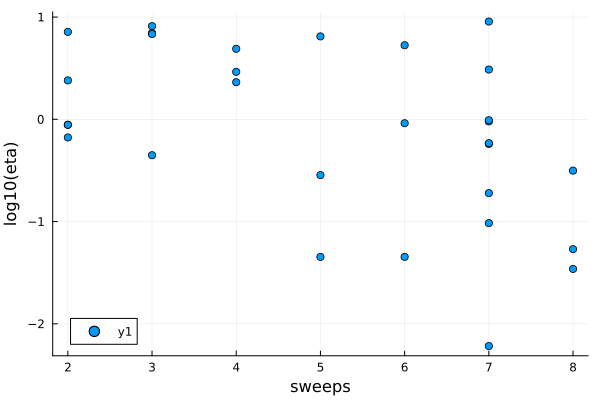

In [73]:
ds, chis, losses, nsw, etas = loss_opts(res_g120)
scatter(nsw,log10.(etas);)
xlabel!("sweeps")
ylabel!("log10(eta)")

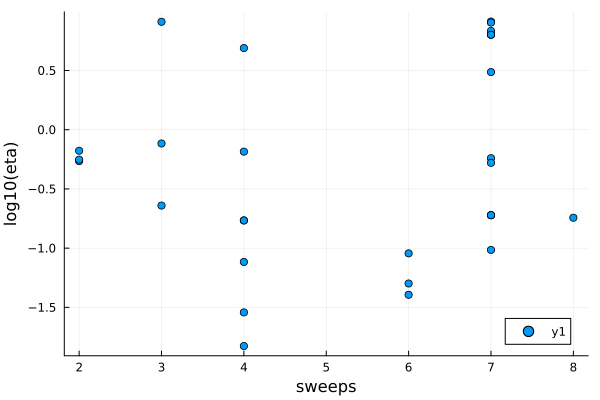

In [72]:
ds, chis, losses, nsw, etas = loss_opts(res_g50)
scatter(nsw,log10.(etas);)
xlabel!("sweeps")
ylabel!("log10(eta)")

In [70]:
etas |> maximum

8.195714442475662

# ECG

In [21]:
@load "ECG200/ECG_rand_50.jld2"
res_r50 = copy(res)

@load "ECG200/ECG_rand_50_5cv.jld2"
res_r50_5cv = copy(res)

@load "ECG200/ECG_rand_50_ns.jld2"
res_r50_ns = copy(res) |> values |> collect

@load "ECG200/ECG_rand_50_ns_more_chi.jld2"
res_r50_ns_2 = copy(res) |> values |> collect

@load "ECG200/ECG_gen_50.jld2"
res_g50 = copy(res)



pms = 5:10:95

res_by_pm_r50, std_by_pm_r50 = loss_by_pm(res_r50, pms)
res_by_pm_r50_5cv, std_by_pm_r50_5cv = loss_by_pm(res_r50_5cv, pms)
res_by_pm_r50_ns, std_by_pm_r50_ns = loss_by_pm(res_r50_ns, pms)
res_by_pm_r50_ns_2, std_by_pm_r50_ns_2 = loss_by_pm(res_r50_ns_2, pms)


res_by_pm_g50, std_by_pm_g50 = loss_by_pm(res_g50, pms)



mmae_by_pm_r50 = mean.(res_by_pm_r50)
mmae_by_pm_r50_5cv = mean.(res_by_pm_r50_5cv)
mmae_by_pm_r50_ns= mean.(res_by_pm_r50_ns)
mmae_by_pm_r50_ns_2= mean.(res_by_pm_r50_ns_2)



mmae_by_pm_g50 = mean.(res_by_pm_g50)


@save "ECG_hyperopt.jld2" pms mmae_by_pm_r50 mmae_by_pm_r50_5cv mmae_by_pm_g50  std_by_pm_r50 std_by_pm_r50_5cv std_by_pm_g50 
# random search 50 - hyperopt uses 3 cross validation folds
# random search 50 - hyperopt uses 5 cross validation folds
# Gen alg (Differential evolution) 50 generations, but that actually means 70 function evalutations so its labelled 70 on the plot

mmae_by_pms = mmae_by_pm_r50_ns
std_by_pms = std_by_pm_r50_ns
@save "ECG_josh.jld2" pms mmae_by_pms std_by_pms

mmae_by_pms = mmae_by_pm_r50_ns_2
std_by_pms = std_by_pm_r50_ns_2
@save "ECG_more_chi_josh.jld2" pms mmae_by_pms std_by_pms

In [48]:
f = jldopen("Josh/ECG/ECG200_ImputationFinalResults_30Fold.jld2", "r");
res_mps = read(f, "mps_results")
res_nn = read(f, "nn_results")
close(f)

instances = length(res_mps[5][1])
mmae_by_pm_paper = [mean([mean([mean(res_mps[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
mmae_by_pm_nn = [mean([mean([mean(res_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10]
std_by_pm_paper = ([std([mean([mean(res_mps[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])
std_by_pm_nn = ([std([mean([mean(res_nn[pm][f][inst]) for inst in 1:instances]) for f in 1:30]) for pm in 1:10])

10-element Vector{Float64}:
 0.008537606769123868
 0.008056621127721247
 0.00787910813251473
 0.008997652275113484
 0.008685880769342853
 0.009466021001200189
 0.010396690530985095
 0.010581085381700543
 0.012327006907051944
 0.014047063929430038

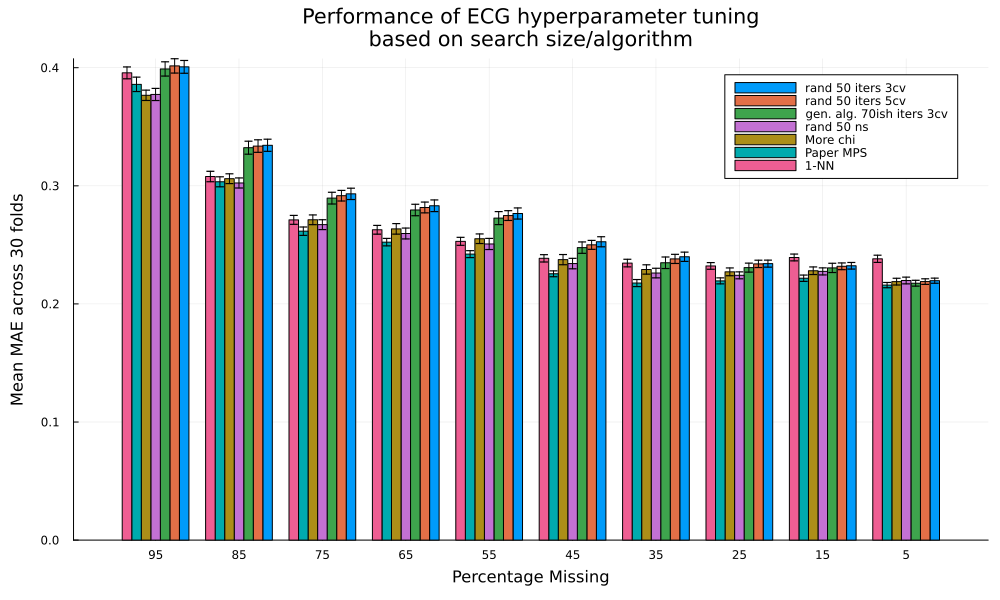

In [30]:
groupedbar(
    pms, 
    [mmae_by_pm_r50 mmae_by_pm_r50_5cv mmae_by_pm_g50 mmae_by_pm_r50_ns mmae_by_pm_r50_ns_2 mmae_by_pm_paper mmae_by_pm_nn]; 
    yerr =1.96 .* [std_by_pm_r50 std_by_pm_r50_5cv std_by_pm_g50 std_by_pm_r50_ns std_by_pm_r50_ns_2 std_by_pm_paper std_by_pm_nn] ./sqrt(30), 
    xticks = pms, 
    labels=["rand 50 iters 3cv" "rand 50 iters 5cv" "gen. alg. 70ish iters 3cv" "rand 50 ns" "More chi" "Paper MPS" "1-NN"], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of ECG hyperparameter tuning\nbased on search size/algorithm")
# savefig("ecg2.svg")

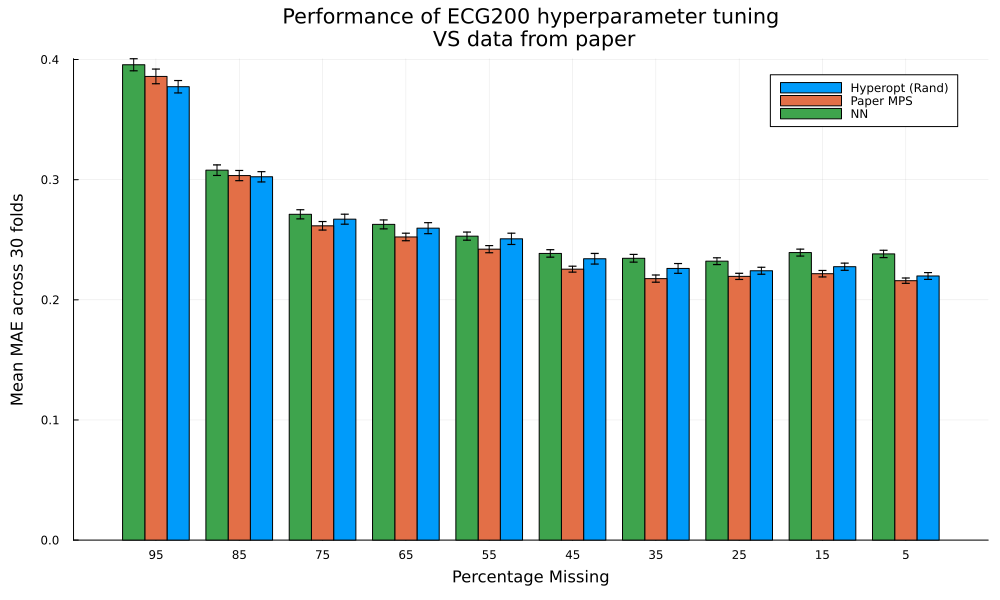

In [50]:
groupedbar(
    pms, 
    [ mmae_by_pm_r50_ns mmae_by_pm_paper mmae_by_pm_nn ]; 
    yerr =1.96 .* [std_by_pm_r50_ns std_by_pm_paper std_by_pm_nn ] ./sqrt(30), 
    xticks = pms, 
    labels=[ "Hyperopt (Rand)" "Paper MPS" "NN" ], 
    legend=:topright,
    size=(1000,600),
    bottom_margin=5mm, 
    left_margin=5mm, 
    top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of ECG200 hyperparameter tuning\n VS data from paper")
# savefig("ECG2A.svg")

In [11]:
getindex.(res, "time")

30-element Vector{Float64}:
 46136.47701096535
 47344.054498910904
 44467.40820097923
 48707.58989882469
 15624.699989080429
 45800.49858093262
 46874.025274038315
 45889.864135980606
 45161.24332308769
 44956.59969687462
     ⋮
 35410.73339796066
 46976.5394589901
 22062.401610851288
 45811.343426942825
 47001.171401023865
 50579.851669073105
 45967.79223012924
 45051.42675805092
 48193.12154388428

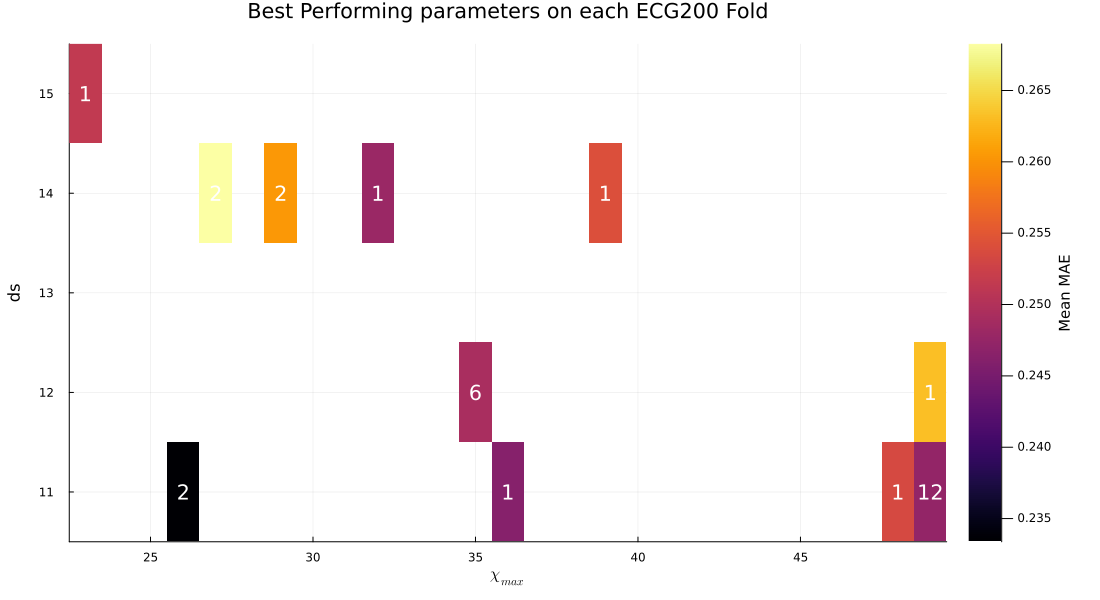

In [89]:
ds, chis, losses, anns = get_hm_vals(res_r50_ns)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG200 Fold")
plot(hm)
# savefig("ECG_heatmap.svg")

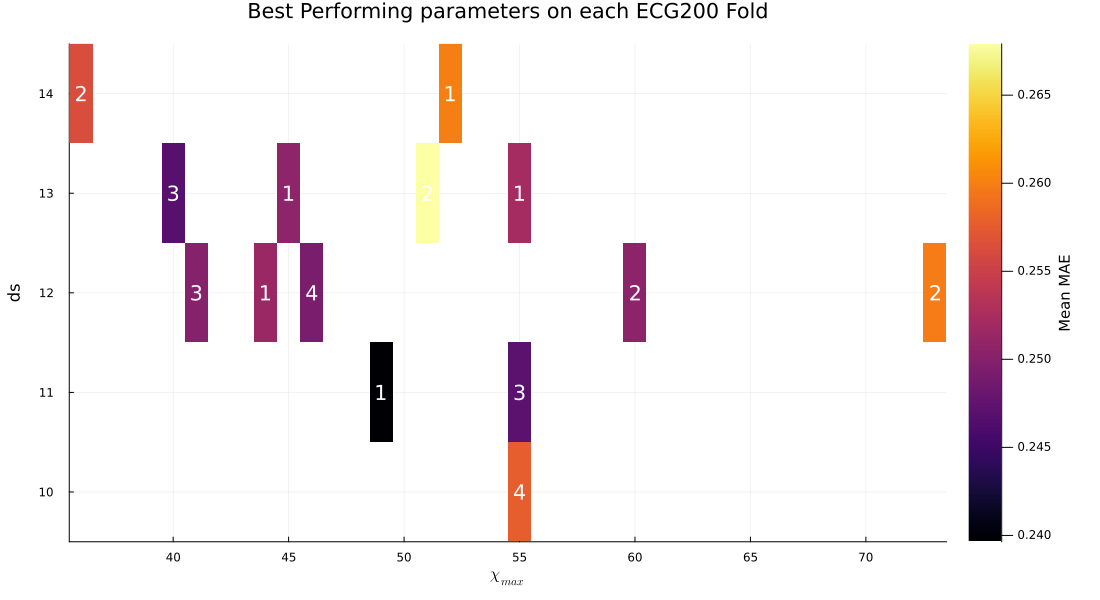

In [ ]:
ds, chis, losses, anns = get_hm_vals(res_r50_ns_2)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG200 Fold")
plot(hm)
savefig("ECG_heatmap.svg")

# Kepler

In [72]:
@load "Kepler/KC4_evals/ImputationLoss()_MPSRandomSearch(:LatinHypercube)_f=30_cv=5_iters=50.jld2" res
res_r50_c4_tuned = copy(res) |> values |> collect

@load "../kepc4_rand_ns_check_2.jld2" res
res_r50_c4 = copy(res) |> values |> collect

@load "Kepler/KC6_evals/ImputationLoss()_MPSRandomSearch(:LatinHypercube)_f=30_cv=5_iters=50.jld2" res
res_r50_c6_tuned = copy(res) |> values |> collect

@load "../kepc6_rand_no_s_check_2.jld2" res
res_r50_c6 = copy(res) |> values |> collect

# opts = MPSOptions(; verbosity=-5, log_level=-1, d=12, chi_max=35, eta=0.1, nsweeps=3, sigmoid_transform=false)
opts = MPSOptions(; verbosity=-5, log_level=-1, d=2, chi_max=5, eta=0.1, nsweeps=3, sigmoid_transform=false)
@load "Kepler/kepler_windows_julia_idx.jld2" windows_per_percentage
eval_windows = reduce(vcat, values(windows_per_percentage))

########################### c4 data and  bounds
rs_f = jldopen("Kepler/c4_folds_flat.jld2", "r");
folds = read(rs_f, "folds");
Xs = read(rs_f, "Xs");
close(rs_f)

ys = zeros(Int64, size(Xs, 1))

tr_inds, te_inds = folds[1]
X_train, X_test, y_train, y_test = Xs[tr_inds,:], Xs[te_inds, :], ys[tr_inds], ys[te_inds]

ex = extrema(X_train)
d_range_c4 = ex[2] - ex[1]
###############################################

nn_mae_c4 = []
for fold in folds
    tr_inds, te_inds = fold
    X_train, X_test, y_train, y_test = Xs[tr_inds,:], Xs[te_inds, :], ys[tr_inds], ys[te_inds]

    mps, _... = fitMPS(X_train, opts)
    imp = init_imputation_problem(mps, X_test; verbosity=-10);

    nn = MPSTime.eval_loss(ImputationLoss(), mps, X_test, y_test .*0, eval_windows, method=:kNearestNeighbour) 
    push!(nn_mae_c4,Dict([("eval_windows", eval_windows), ("loss", nn)])])
end
########################### c6 data and  bounds
rs_f = jldopen("Kepler/c6_folds_flat.jld2", "r");
folds = read(rs_f, "folds");
Xs = read(rs_f, "Xs");
close(rs_f)

ys = zeros(Int64, size(Xs, 1))
tr_inds, te_inds = folds[1]
X_train, X_test, y_train, y_test = Xs[tr_inds,:], Xs[te_inds, :], ys[tr_inds], ys[te_inds]

ex = extrema(X_train)
d_range_c6 = ex[2] - ex[1]
############################

nn_mae_c6 = []
for fold in folds
    tr_inds, te_inds = fold
    X_train, X_test, y_train, y_test = Xs[tr_inds,:], Xs[te_inds, :], ys[tr_inds], ys[te_inds]

    mps, _... = fitMPS(X_train, opts)
    imp = init_imputation_problem(mps, X_test; verbosity=-10);

    nn = MPSTime.eval_loss(ImputationLoss(), mps, X_test, y_test .*0, eval_windows, method=:kNearestNeighbour) 
    push!(nn_mae_c6,Dict([("eval_windows", eval_windows), ("loss", nn)])])
end
pms = 5:10:95 |> collect


################ Old paper data
@load "Josh/Kepler/KC4_paper.jld2" res_mps_c4 res_nn_c4 std_mps_c4 std_nn_c4
@load "Josh/Kepler/KC6_paper.jld2" res_mps_c6 res_nn_c6 std_mps_c6 std_nn_c6

res_mps_c4_old = res_mps_c4 ./ d_range_c4
res_nn_c4_old = res_nn_c4 ./ d_range_c4
ste_mps_c4_old = std_mps_c4 ./ d_range_c4
ste_nn_c4_old = std_nn_c4 ./ d_range_c4

res_mps_c6_old = res_mps_c4 ./ d_range_c6
res_nn_c6_old = res_nn_c4 ./ d_range_c6
ste_mps_c6_old = std_mps_c4 ./ d_range_c6
ste_nn_c6_old = std_nn_c4 ./ d_range_c6

################

res_by_pm_r50_c4, std_by_pm_r50_c4 = loss_by_pm(res_r50_c4_tuned, pms; scale=d_range_c4)
res_mps_c4, std_mps_c4 = loss_by_pm(res_r50_c4, pms; scale=d_range_c4)
res_nn_c4, std_nn_c4 = loss_by_pm(nn_mae_c4, pms; scale=d_range_c4)


res_by_pm_r50_c6, std_by_pm_r50_c6 = loss_by_pm(res_r50_c6_tuned, pms; scale=d_range_c6)
res_mps_c6, std_mps_c6 = loss_by_pm(res_r50_c6, pms; scale=d_range_c6)
res_nn_c6, std_nn_c6 = loss_by_pm(nn_mae_c6, pms; scale=d_range_c6)



mmae_by_pm_r50_c4 = mean.(res_by_pm_r50_c4)
mmae_mps_c4 = mean.(res_mps_c4)
mmae_nn_c4 = mean.(res_nn_c4)

mmae_by_pm_r50_c6 = mean.(res_by_pm_r50_c6)
mmae_mps_c6 = mean.(res_mps_c6)
mmae_nn_c6 = mean.(res_nn_c6)


@show d_range_c4
@show d_range_c6


Base.Meta.ParseError: ParseError:
# Error @ /home/noodles/.julia/dev/MPSTime/Folds/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:42:73
    nn = MPSTime.eval_loss(ImputationLoss(), mps, X_test, y_test .*0, eval_windows, method=:kNearestNeighbour) 
    push!(nn_mae_c4,Dict([("eval_windows", eval_windows), ("loss", nn)])])
#                                                                       └ ── Expected `)`

In [71]:
mmae_nn_c4 ./ res_nn_c4_old

10-element Vector{Float64}:
 1.6189620269822669
 1.6373355841880999
 1.6774502340227029
 1.612198778953284
 1.65622183900721
 1.6413630867293934
 1.703061934671089
 1.6155403645235529
 1.588704031940548
 1.5491321246844778

In [ ]:
groupedbar(
    pms, 
    [mmae_by_pm_r50_c4 mmae_mps_c4 mmae_nn_c4 mmae_by_pm_r50_c6 mmae_mps_c6 mmae_nn_c6 ]; 
    # yerr =1.96 .* [std_by_pm_r50_c4 std_mps_c4 [0 for _ in std_nn_c4] std_by_pm_r50_c6 std_mps_c6 [0 for _ in std_nn_c6]] ./sqrt(30) , 
    yerr =1.96 .* [std_by_pm_r50_c4 std_mps_c4 std_nn_c4 std_by_pm_r50_c6 std_mps_c6 std_nn_c6] ./sqrt(30) , 
    xticks = pms, 
    labels=["rand 50 c4" "Paper MPS C4" "NN C4" "rand 50 c6" "Paper MPS C6" "NN C6"], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler hyperparameter tuning")
savefig("Kepler2.png")

"/home/noodles/.julia/dev/MPSTime/Folds/Kepler2.png"

In [25]:
res_by_pm, std_by_pm = loss_by_pm(res, pms)
mmae_by_pm = mean.(res_by_pm)

10-element Vector{Float64}:
 0.21700484548881993
 0.22926639197894405
 0.2307535780010371
 0.23533699156825172
 0.24939616187836458
 0.27246777114922255
 0.2814984385389548
 0.28918904965493
 0.33031928354754253
 0.3968192596758313

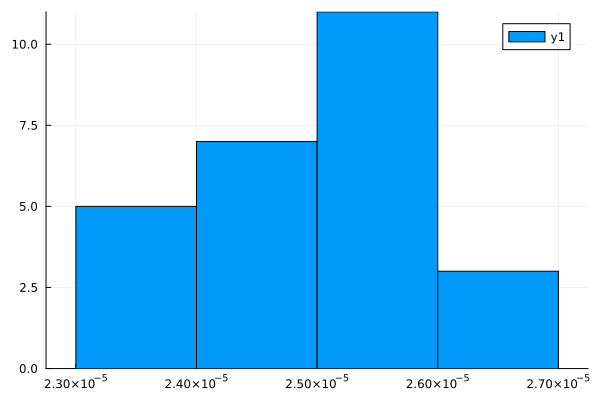

In [15]:
getindex.(res_r50_c4, "loss") .|> mean |> histogram

In [50]:
ds, chis, losses, anns = get_hm_vals(res_r50_c4)
hm =heatmap(ds, chis, losses ./ d_range_c4,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each KEPLER (C4) Fold")
plot(hm)
savefig("KEPC4_heatmap.svg")

"/home/noodles/.julia/dev/MPSTime/Folds/KEPC4_heatmap.svg"

In [49]:
ds, chis, losses, anns = get_hm_vals(res_r50_c6)
hm =heatmap(ds, chis, losses ./ d_range_c6,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each KEPLER (C6) Fold")
plot(hm)
savefig("KEPC6_heatmap.svg")

"/home/noodles/.julia/dev/MPSTime/Folds/KEPC6_heatmap.svg"

In [22]:
rs_f = jldopen("Kepler/c4_folds_flat.jld2", "r");
folds = read(rs_f, "folds");
Xs = read(rs_f, "Xs");
close(rs_f)
ys = ones(Int, size(Xs, 1))

@load "Kepler/kepler_windows_julia_idx.jld2" windows_per_percentage
windows_julia = windows_per_percentage

Dict{Any, Any} with 10 entries:
  0.65 => [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  57, 58, 59, 60, 61, 62, 63, 64, …
  0.95 => [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  87, 88, 89, 90, 91, 92, 93, 94, …
  0.85 => [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  77, 78, 79, 80, 81, 82, 83, 84, …
  0.15 => [[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91], [64, 6…
  0.55 => [[13, 14, 15, 16, 17, 18, 19, 20, 21, 22  …  58, 59, 60, 61, 62, 63, …
  0.45 => [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16  …  42, 43, 44, 45, 46, 47, 48,…
  0.75 => [[21, 22, 23, 24, 25, 26, 27, 28, 29, 30  …  86, 87, 88, 89, 90, 91, …
  0.25 => [[58, 59, 60, 61, 62, 63, 64, 65, 66, 67  …  73, 74, 75, 76, 77, 78, …
  0.35 => [[42, 43, 44, 45, 46, 47, 48, 49, 50, 51  …  67, 68, 69, 70, 71, 72, …
  0.05 => [[39, 40, 41, 42, 43], [8, 9, 10, 11, 12], [83, 84, 85, 86, 87], [11,…